# MNIST Prediction with Artificial Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.
- Reference: [Oddly Satisfying Deep Learning](https://pythonandml.github.io/dlbook/content/convolutional_neural_networks/cnn_over_mlp.html)

#### Import libraries

In [137]:
# for linear algebra
import numpy as np

# for plotting data, loss, accuracy
import matplotlib.pyplot as plt

# loading mnist dataset from keras
from keras import datasets

# show progress bar
from tqdm import tqdm

# for type hinting
from typing import Optional

## 1. Utility Functions

1. **plot_data**: plot the random 8 images from the dataset.
2. **Activation Functions**: Linear, reLU, Sigmoid, Tanh, Softmax.
3. **Weight Initialization**: Zeros, Ones, Random, Random Uniform.
4. **Optimization Functions**: Gradient Descent, Stochastic Gradient Descent, RMSprop, Adam.

In [138]:
class BaseLayer:
    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        :param X: input data

        :return: output of the layer
        """
        pass

    def backpropagation(self, dZ: np.ndarray, lr: int) -> np.ndarray:
        """
        :param dZ: gradient of the loss with respect to the linear output of this layer
        :param lr: learning rate

        :return: update parameters and input gradient
        """
        pass

### 1.1. Plotting Functions

In [139]:
def plot_data(
    X: np.ndarray, y: np.ndarray, y_proba: Optional[np.ndarray] = None
) -> None:
    nrows, ncols = 2, 4
    _, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"
        color = "black"

        if y_proba is not None:
            pred_label = f"Pred: {y_proba[img_idx]}"
            color = "green" if y[img_idx] == y_proba[img_idx] else "red"

        img_title = true_label if y_proba is None else f"{true_label}\n{pred_label}"
        ax.set_xlabel(img_title, color=color)

    plt.tight_layout()
    plt.show()

### 1.2. Activation Functions and Their Derivatives class

- Sigmoid function: $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Derivative of sigmoid function: $\sigma'(z) = \sigma(z)(1 - \sigma(z))$

- ReLU function: $f(z) = \max(0, z)$
- Derivative of ReLU function: $f'(z) = 0$ if $z < 0$ and $f'(z) = 1$ if $z \geq 0$

- Tanh function: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$
- Derivative of tanh function: $\tanh'(z) = 1 - \tanh^2(z)$

In [216]:
class Activation(BaseLayer):
    def __init__(self, act: str = None) -> None:
        if act is None:
            self.act = "relu"
        else:
            self.act = act

    def linear(self, x: np.ndarray) -> np.ndarray:
        return x

    def d_linear(self, x: np.ndarray) -> np.ndarray:
        return np.ones(x.shape)

    def reLU(self, x: np.ndarray) -> np.ndarray:
        return x * (x > 0)

    def d_reLU(self, x: np.ndarray) -> np.ndarray:
        return (x > 0) * np.ones(x.shape)

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x: np.ndarray) -> np.ndarray:
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)

    def d_tanh(self, x: np.ndarray) -> np.ndarray:
        return 1 - self.tanh(x) ** 2

    def get_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act == "linear":
            return self.linear(X)
        elif self.act == "sigmoid":
            return self.sigmoid(X)
        elif self.act == "tanh":
            return self.tanh(X)
        elif self.act == "reLU":
            return self.reLU(X)
        else:
            raise ValueError("Activation function not recognized")

    def get_d_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act == "linear":
            return self.d_linear(X)
        elif self.act == "sigmoid":
            return self.d_sigmoid(X)
        elif self.act == "tanh":
            return self.d_tanh(X)
        elif self.act == "reLU":
            return self.d_reLU(X)
        else:
            raise ValueError("Activation function not recognized")

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        return self.get_activation(X)

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        return np.multiply(dZ, self.get_d_activation(self.X))

### 1.3. Weight Initialization class

- Zeros initialization: $w = np.zeros(shape)$
- Ones initialization: $w = np.ones(shape)$
- Random initialization: $w = np.random.randn(shape)$
- Random uniform initialization: $w = np.random.uniform(size=shape)$

In [141]:
class WeightInitializer(BaseLayer):
    def __init__(self, shape, init: str = None, seed: int = None) -> None:
        """
        :param shape: shape of the weight matrix
        :param init: type of initialization (available initializations: zeros, ones, random, random_uniform)
        :param seed: seed for random initialization
        """
        self.shape = shape

        if init is None:
            self.init = "random"
        else:
            self.init = init

        if seed is None:
            self.seed = 69
        else:
            self.seed = seed

    def zeros(self) -> np.ndarray:
        return np.zeros(self.shape)

    def ones(self) -> np.ndarray:
        return np.ones(self.shape)

    def random(self) -> np.ndarray:
        np.random.seed(self.seed)
        return np.random.randn(*self.shape)

    def random_uniform(self) -> np.ndarray:
        np.random.seed(self.seed)
        return np.random.uniform(size=self.shape)

    def get_initializer(self) -> np.ndarray:
        if self.init == "zeros":
            return self.zeros()
        elif self.init == "ones":
            return self.ones()
        elif self.init == "random":
            return self.random()
        elif self.init == "random_uniform":
            return self.random_uniform()
        else:
            raise ValueError(
                "Valid initializations are: zeros, ones, random, random_uniform"
            )

### 1.4.  Optimizers class

- Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- Stochastic Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- RMSprop Optimizer: $v = \beta v + (1 - \beta) \nabla_w L(w) \odot \nabla_w L(w)$ and $w = w - \alpha \frac{\nabla_w L(w)}{\sqrt{v + \epsilon}}$
- Adam Optimizer: $m = \beta_1 m + (1 - \beta_1) \nabla_w L(w)$, $v = \beta_2 v + (1 - \beta_2) \nabla_w L(w) \odot \nabla_w L(w)$, $m_{\text{corrected}} = \frac{m}{1 - \beta_1^t}$, $v_{\text{corrected}} = \frac{v}{1 - \beta_2^t}$, and $w = w - \alpha \frac{m_{\text{corrected}}}{\sqrt{v_{\text{corrected}} + \epsilon}}$

> Note: Actually, i only use the Gradient Descent Optimizer in this notebook.

In [142]:
class Optimizer:
    def __init__(
        self,
        op_type: str = None,
        shape_W: tuple[int, int] = None,
        shape_b: tuple[int, int] = None,
        m1: float = 0.9,
        m2: float = 0.999,
        epsilon: int = 1e-8,
    ) -> None:
        """
        :param op_type: type of optimizer (available optimizers: GD, SGD, RMSProp, Adam)
        :param shape_W: shape of the weight matrix
        :param shape_b: shape of the bias matrix
        :param m1: hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations. Used in RMSprop
        :param m2: hyperparameter for adam only
        :param epsilon: parameter used in adam and RMSprop to prevent division by zero error
        """
        if op_type is None:
            self.op_type = "GD"
        else:
            self.op_type = op_type

        self.m1 = m1
        self.m2 = m2
        self.epsilon = epsilon

        self.vdW = np.zeros(shape_W)
        self.vdb = np.zeros(shape_b)

        self.SdW = np.zeros(shape_W)
        self.Sdb = np.zeros(shape_b)

    def GD(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        return dW, db

    def SGD(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        return self.vdW, self.vdb

    def RMSProp(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        den_W = np.sqrt(self.SdW) + self.epsilon
        den_b = np.sqrt(self.Sdb) + self.epsilon

        return dW / den_W, db / den_b

    def Adam(self, dW: np.ndarray, db: np.ndarray, k: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        # momentum
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        # rmsprop
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        # correction
        if k > 1:
            vdW_h = self.vdW / (1 - (self.momentum1**k))
            vdb_h = self.vdb / (1 - (self.momentum1**k))
            SdW_h = self.SdW / (1 - (self.momentum2**k))
            Sdb_h = self.Sdb / (1 - (self.momentum2**k))
        else:
            vdW_h = self.vdW
            vdb_h = self.vdb
            SdW_h = self.SdW
            Sdb_h = self.Sdb

        den_W = np.sqrt(SdW_h) + self.epsilon
        den_b = np.sqrt(Sdb_h) + self.epsilon

        return vdW_h / den_W, vdb_h / den_b

    def get_optimizer(self, dW: np.ndarray, db: np.ndarray, k: int) -> tuple:
        if self.op_type == "GD":
            return self.GD(dW, db, k)
        elif self.op_type == "SGD":
            return self.SGD(dW, db, k)
        elif self.op_type == "RMSProp":
            return self.RMSProp(dW, db, k)
        elif self.op_type == "Adam":
            return self.Adam(dW, db, k)
        else:
            raise ValueError("Valid optiomizers are GD, SGD, RMSProp, Adam")

### 1.5. Mean Squared Error class

In [202]:
class MSE:
    def __init__(self, y_true: np.ndarray, y_pred: np.ndarray) -> None:
        """
        :param y_true: true labels
        :param y_pred: predicted labels
        """
        self.y_true = y_true
        self.y_pred = y_pred

    def forward(self) -> float:
        return np.mean(np.power(self.y_true - self.y_pred, 2))

    def backpropagation(self) -> np.ndarray:
        return 2 * (self.y_pred - self.y_true) / np.size(self.y_true)

## 2. Load Data

- Load the MNIST dataset from the `keras.datasets.mnist` module.
- Split the dataset into training and testing sets.

In [144]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

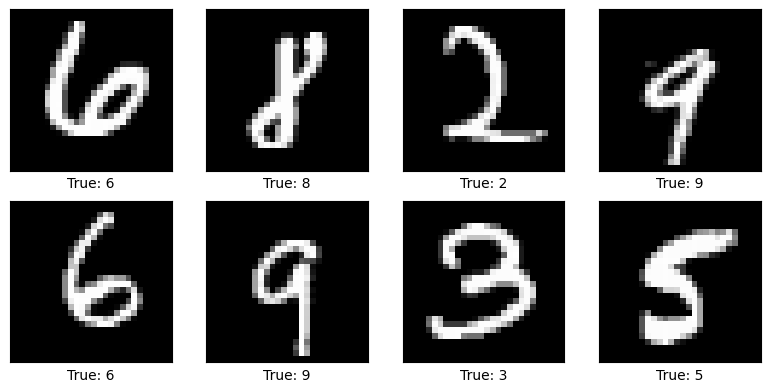

In [145]:
plot_data(X_train, y_train)

## 3. Image Preprocessing

- Normalize the images by dividing each pixel by 255.
- Add channel dimension to the images.
- Convert y to one-hot encoding.

In [146]:
# Convert to float32 and scale to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [147]:
# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [148]:
print("x_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

x_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [149]:
"""Conver y to one-hot encoding. Example:
y = 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
"""

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [150]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (60000, 10)
y_test shape: (10000, 10)


## 4. Artificial Neural Network

### 4.1. With Convolutional Neural Network

#### 4.1.1. Dense Layer

In [224]:
class Dense(BaseLayer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

> Testing MLB Model with XOR Dataset

In [225]:
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [Dense(1, 3), Activation("tanh"), Dense(1, 1), Activation("tanh")]
epochs = 10
learning_rate = 0.1

for e in range(epochs):
    error = 0
    for x, y in zip(X, y):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)

        # error
        mse = MSE(y, output)
        error += mse.forward()

        # backward
        grad = mse.backpropagation()
        for layer in reversed(network):
            grad = layer.backpropagation(grad, learning_rate)

    error /= len(X)
    print(f"{e + 1}/{epochs}, error={error}")

ValueError: shapes (3,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)

### 4.2 With Keras

In [152]:
from keras import models, layers

In [153]:
inp_shape = X_train.shape[1:]

In [154]:
model = models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [156]:
batch_size = 128
epochs = 5

history = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)

Epoch 1/5
422/422 [==============================] - 1s 2ms/step - loss: 0.4347 - accuracy: 0.8741 - val_loss: 0.0991 - val_accuracy: 0.9688
Epoch 2/5
422/422 [==============================] - 1s 2ms/step - loss: 0.0869 - accuracy: 0.9728 - val_loss: 0.0722 - val_accuracy: 0.9775
Epoch 3/5
 66/422 [===>..........................] - ETA: 0s - loss: 0.0468 - accuracy: 0.9858

422/422 [==============================] - 1s 2ms/step - loss: 0.0532 - accuracy: 0.9832 - val_loss: 0.0751 - val_accuracy: 0.9760
Epoch 4/5
422/422 [==============================] - 1s 2ms/step - loss: 0.0360 - accuracy: 0.9889 - val_loss: 0.0812 - val_accuracy: 0.9777
Epoch 5/5
422/422 [==============================] - 1s 2ms/step - loss: 0.0262 - accuracy: 0.9921 - val_loss: 0.0768 - val_accuracy: 0.9777


#### 4.2.1. Model results

In [157]:
history_dict = history.history

In [158]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [159]:
train_loss, val_loss = history_dict["loss"], history_dict["val_loss"]
train_acc, val_acc = history_dict["accuracy"], history_dict["val_accuracy"]

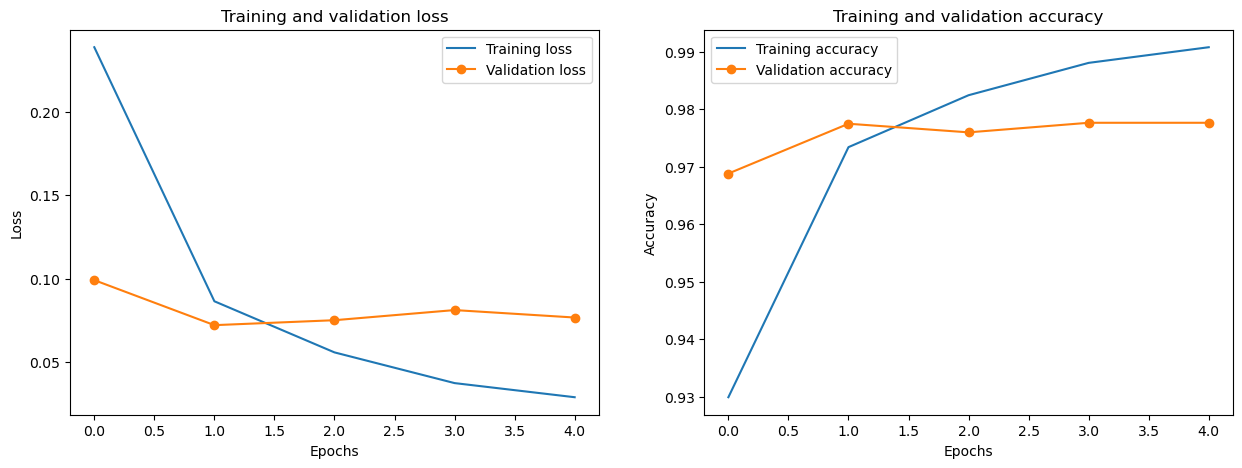

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_run = [i for i in range(epochs)]

ax1.plot(epochs_run, train_loss, label="Training loss")
ax1.plot(epochs_run, val_loss, label="Validation loss", marker="o")

ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs_run, train_acc, label="Training accuracy")
ax2.plot(epochs_run, val_acc, label="Validation accuracy", marker="o")

ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

#### 4.2.1. Model prediction

In [161]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.07233430445194244
Test accuracy: 0.9782999753952026


In [162]:
y_pred = model.predict(X_test)

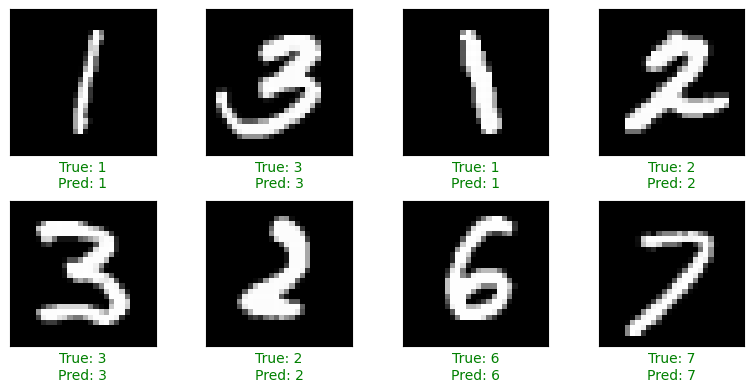

In [163]:
plot_data(X_test, np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))